In [1]:
!pip install datascience

    100% |████████████████████████████████| 51kB 15.7MB/s 
    100% |████████████████████████████████| 1.6MB 1.1MB/s 
    100% |████████████████████████████████| 163kB 9.3MB/s 
    100% |████████████████████████████████| 286kB 5.8MB/s 
    100% |████████████████████████████████| 71kB 12.8MB/s 
    100% |████████████████████████████████| 7.1MB 247kB/s 
    100% |████████████████████████████████| 512kB 2.9MB/s 
    100% |████████████████████████████████| 92kB 13.6MB/s 
  Running setup.py bdist_wheel for datascience ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/68/1a/d2/ccf011f928ee4c13da6fd8409160a13456d460d263ccbf931d
  Running setup.py bdist_wheel for folium ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/97/f3/25/51a7acd11b6663869c0723fe1c3f63c74725f3243d01d61ea7
  Running setup.py bdist_wheel for coverage ... - \ | / done
  Stored in directory: /home/jovyan/.cache/pip/wheels/09/d5/14/fad8864342631171117f01b9b2473a07c053e5c1054d4

In [4]:
from datascience import *
from datascience.predicates import are
import numpy as np
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import random
from collections import defaultdict

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [6]:
THRESHOLD = 0.9
WINDOW = 10
BLOCK = 10000

In [7]:
dna = "ACGT"

comp = {
    'A': 'T',
    'T': 'A',
    'C': 'G',
    'G': 'C',
    'N': 'N',
}

def revcomp(seq):
    return ''.join(comp[a] for a in reversed(seq))

def make_seq(k):
    return ''.join(dna[randint(0, 3)] for i in range(k))

def perc_id(s1, s2):
    assert len(s1) == len(s2)
    matches = sum(
        1
        for i in range(len(s1))
        if s1[i] == s2[i] and s1[i] != 'N'
    )
    return matches / float(len(s1))

def calc_synteny(s1, s2, k, threshold):
    mat = []
    for i in range(len(s1) - k):
        for j in range(len(s2) - k):
            window1 = s1[i:i + k]
            window2 = s2[j:j + k]
            score1 = perc_id(window1, window2)
            score2 = perc_id(window1, revcomp(window2))
            max_score = max(score1, score2)
            if max_score > threshold:
                mat.append((i, j, max_score))
    return mat

In [8]:
def calc_match(row):
    (i, s1), (j, s2) = row
    score1 = perc_id(s1, s2)
    score2 = perc_id(s1, revcomp(s2))
    max_score = max(score1, score2)
    
    return i, j, max_score

In [9]:
human_table = defaultdict(list)

with open('../hg38/hg38.out', 'r') as f:
    i = 0
    while True:
        f.seek(i)
        substr = f.read(WINDOW).upper()
        i += BLOCK
        
        if not substr:
            break
        human_table[substr].append(i)
human_table

defaultdict(list,
            {'AGCCACTGCA': [277950000, 731000000, 2137920000, 2537240000],
             'CAAGAAGGGA': [44530000],
             'GAAAAGGCTA': [1046950000, 1118760000],
             'TCCAAATTAC': [336860000],
             'TCTCTAAAGT': [485830000, 930600000],
             'TGCAACTAAT': [2534060000],
             'GAGAATGCAG': [965070000],
             'GCTCTTGTAA': [637230000],
             'GTGTGCAGTG': [446560000],
             'GAGAGCTGAC': [1028000000],
             'TTGTCAGGGG': [1804670000],
             'ACTCTTTCTA': [482160000, 837450000],
             'AAACTGTGGT': [163050000],
             'GCCTTTTAAG': [379170000, 2980390000],
             'GCATAAAAAA': [1845790000],
             'GGTTTGGATA': [835030000],
             'AGAGAGGGAG': [2577550000],
             'CATCGTAACT': [1262830000],
             'AACATCCAAA': [2364290000],
             'CCCAAACCAT': [2951090000],
             'GCCCCTGAGC': [556110000, 2271240000],
             'GATACGGTCT': [2826230000],


In [10]:
with open('../mm10/mm10.out','r') as f:
    f.seek(3000000)
    mouse = f.read(1000000).upper()
mouse[:1000]

'TTCTGTTTCTATTTTGTGGTTACTTTGAGGAGAGTTGGAATTAGGTCTTCTTTGAAGGTCTGGTAGAACTCTGCATTAAACCCATCTGGTCCTGGGCTTTTTTTTTTTTTTTTTTTTTTTTTTGGGTGGGAGACTATTGATGACTGCCTCTATTTCTTTAGGGGAAATGGGACTTTTAGTCCATGAATCTGATCCTGATTTAGCTTTGGTACCTGGTATCTGTCTAGGAAGTTGTCCATTTCATCCAGGTTTTCCTGGTTTTTTTTTAGTATAGCCTTTCATAGTAAAATCTGATGATGTTTTTGATATCCTCATGTTCTGTTGGTATGTCTCCTTTTTCATTTCTGATTTTGTTAATTATAGTACAGTCCCTATGCCCTCTAGTTAGTCTGGCTAAGGGTTTATCTATCTTGTTGACTTTCTCAAAGAACCAGCTACTATTTTGGTTGATTCTTTGAATATTTCTTTTTGTTTCCACTTGGTTGATTTCAGCTCTGAGTTTGATTATTTCCTGCTGTCTACTCATCTTGGGTGAATTTGCTTCCTTTTGTTCTAGAGCTTCTAGATTTGCTGTCAGGCTGCTAGTGTATACTCTAGTTTCCTTTTGGAGGCACACAGGCCTGTGAGTTTTACTCTTAGGACTGCCTCATTGTGCCCCATATGTTTGGCTATGTTGTGGATTTATTTTCATTAAACTTTAAAACATCTTTAATTTTTTTCTTTATTTCATCATTGACCAAGCTATCATTAAGTAGAGTATTGTTCAGTTTCCAGGTGAATGTTGGCTTTCTATTATTTATGCTGTTATTGAAGATCAGCCTTAGTCCGTAGTTATCTGAAAGGATGCATGGGAAAATTTCAATATTTTTGTATCTGTTGAGGACTTTTTGTGAGTGACTATATGGTCAATTTTGGAGGATTTGGTACTGAGAAGAAGGTATATATCCTTTTGTCTTATGATAAAATGTTCTGTAGATATCTATTAAATTCATTTGTTTC

In [12]:
i_range = range(len(mouse) - WINDOW)
i_range

range(0, 999990)

In [14]:
windows = [(i, mouse[i:i + WINDOW]) for i in i_range]


In [15]:
def lookup(row):
    i, mouse_substr = row
    return [(i, j, 1.0) for j in human_table[mouse_substr]]

In [16]:
%%time

rdd = sc.parallelize(windows)

result = (
    rdd
    .flatMap(lookup)
    .take(5)
)

CPU times: user 3.7 s, sys: 64 ms, total: 3.76 s
Wall time: 6.09 s


In [17]:
tabled = Table(['i', 'j', 'score']).with_rows(result)
tabled

i,j,score
0,2142880000,1
1,986030000,1
2,1822180000,1
3,688940000,1
3,1438310000,1


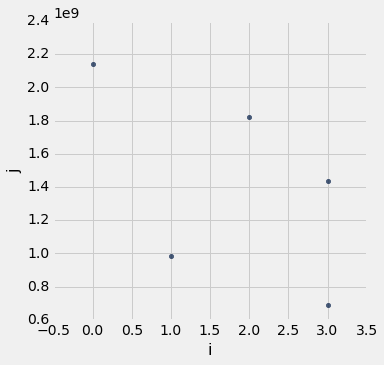

In [18]:
tabled.select('i', 'j').sort('i').scatter('i')